## public transport investment planning
In the following case, a strongly simplified portfolio of a public transport company is optimized. The optimal configuration of buses is to be selected for three bus routes with different average passenger transportations per weekday. The goal is to minimize both variable and fixed costs simultaneously. 

## ÖPNV Portfoliooptimierung
Im nachfolgenden Fall wird ein stark vereinfachtest Portfolio eines Unternehmens des ÖPNV optimiert. Dabei soll für drei Busrouten mit unterschiedlichen durchschnittlichen Personenbeförderungen pro Wochentag die optimale Konstellation an Bussen gewählt werden, um ganzheitlich die variablen und die Investmentkosten zu minimieren. 

### data analyses

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

<IPython.core.display.Javascript object>


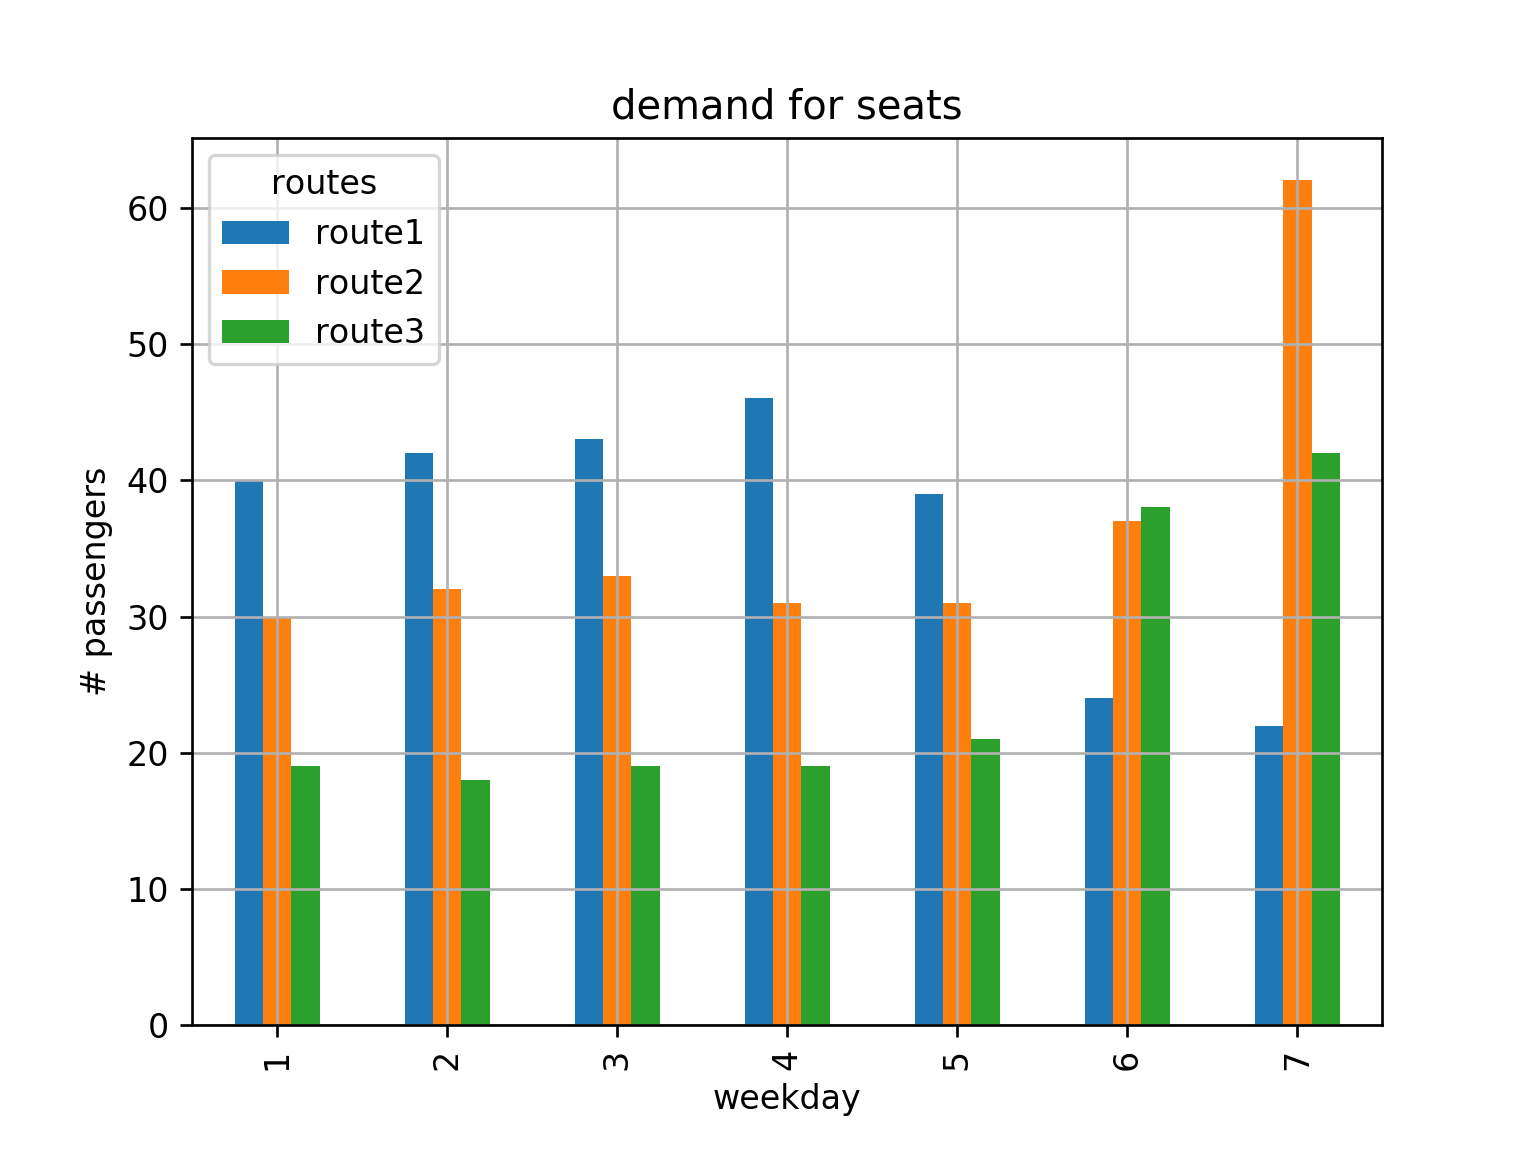

Text(0.5, 1.0, 'demand for seats')

In [2]:
demand = pd.read_csv('demand.csv', index_col=0)
demand.index.name = 'weekday'
demand.columns.name = 'routes'

ax = demand.plot(kind='bar', grid=True)
ax.set_ylabel('# passengers')
ax.set_title('demand for seats')

In [3]:
busses = pd.read_csv('busses.csv', index_col=0)
busses.columns = [c.replace('_', ' ') for c in busses.columns]
busses

,seats,weekly annuity,daily consumption
size,,,
small,33,278,60
medium,40,331,75
large,51,385,90


<IPython.core.display.Javascript object>


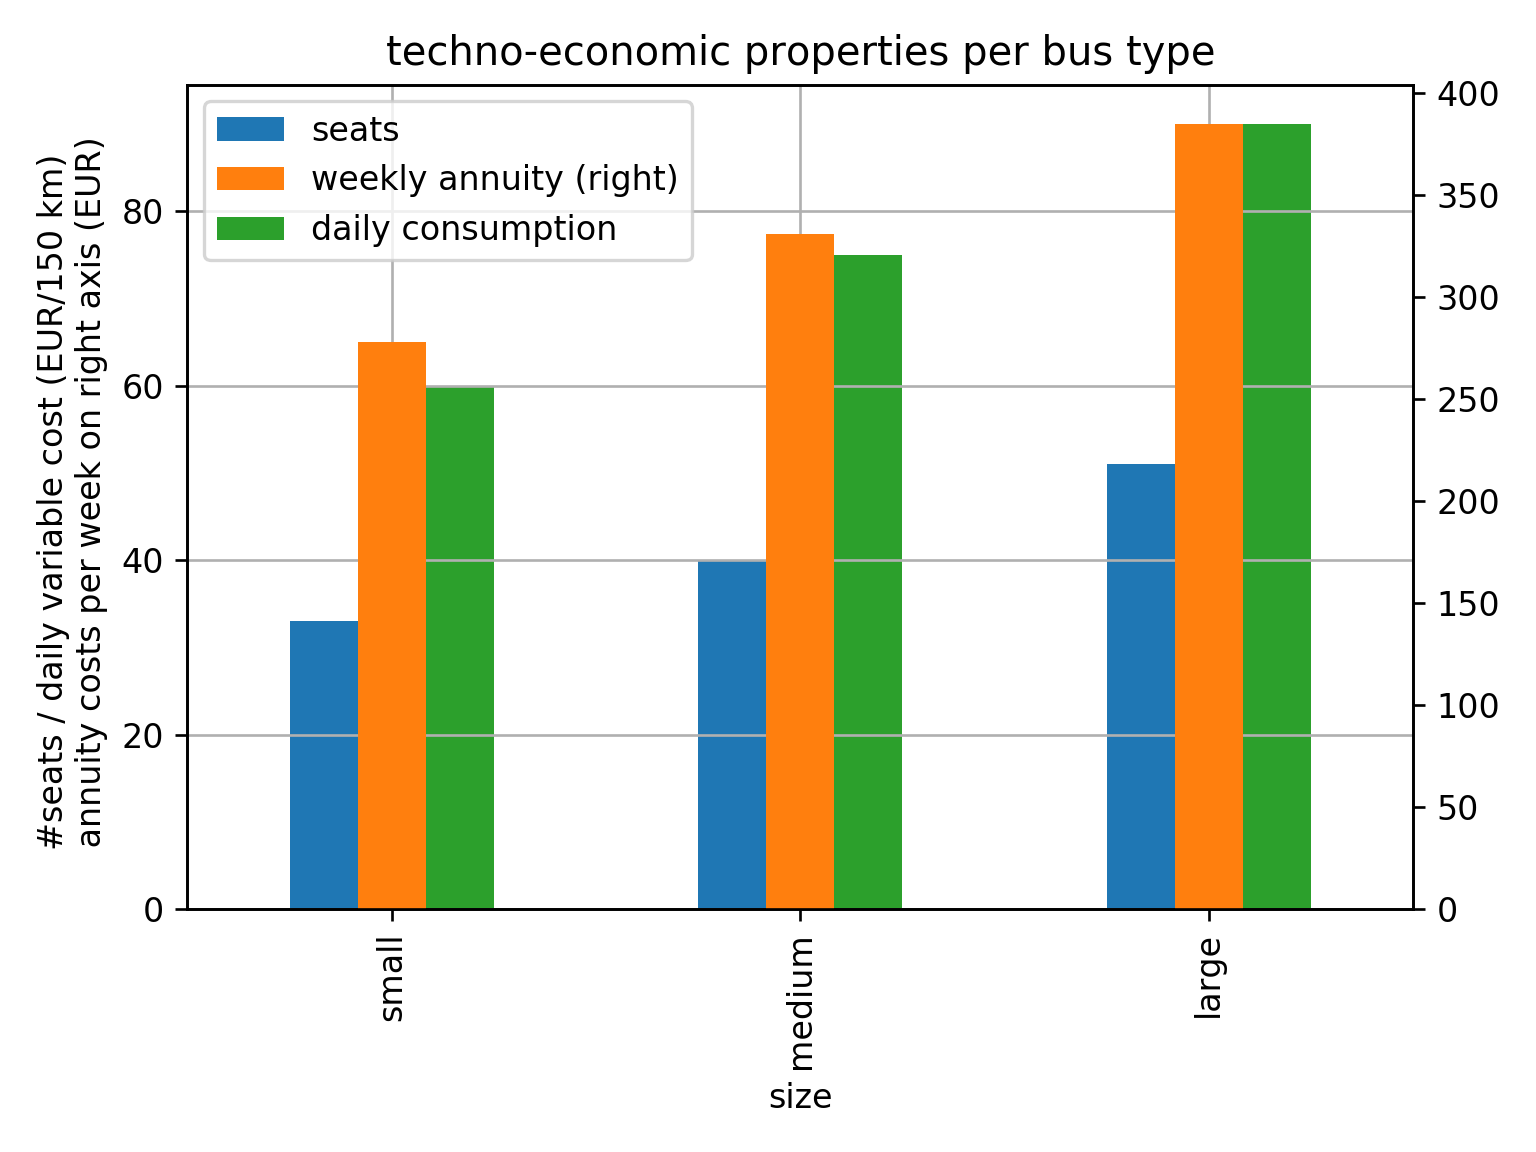

In [4]:
ax = busses.plot(kind='bar', secondary_y='weekly annuity', grid=True)
ax.set_title('techno-economic properties per bus type')
ax.set_ylabel('#seats / daily variable cost (EUR/150 km) \n annuity costs per week on right axis (EUR)')

plt.tight_layout()

### model formulation and optimization

In [5]:
# %load main.py
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory


opt = SolverFactory('cbc')

m = pyo.AbstractModel()
m.sizes = pyo.Set(doc='bus sizes')
m.days = pyo.Set(doc='days per week/operating days')
m.routes = pyo.Set(doc='routes')
m.Cost_fix = pyo.Param(m.sizes, doc='fixed cost per bus')
m.Seats = pyo.Param(m.sizes, doc='seats per bus size')
m.Cost_var = pyo.Param(m.sizes, doc='variable cost per route and day')
m.Demand = pyo.Param(m.days, m.routes, doc='seats to be satisfied')
m.busses = pyo.Var(m.sizes, within=pyo.NonNegativeIntegers, doc='total busses per size')
m.busses_disp = pyo.Var(m.sizes, m.routes, m.days,
                        within=pyo.NonNegativeIntegers,
                        doc='dispatched busses')


def obj_expression(m):
    return (sum(m.Cost_fix[size] * m.busses[size] for size in m.sizes)
            +
            sum(m.busses_disp[size, route, day] * m.Cost_var[size]
                  for size in m.sizes
                  for route in m.routes
                  for day in m.days))


def demand_satisfaction(m, day, route):
    return m.Demand[day, route] <= sum(m.Seats[size] * m.busses_disp[size, route, day]
                                       for size in m.sizes)


def bus_dispatch(m, size, day):
    return sum(m.busses_disp[size, r, day] for r in m.routes) <= m.busses[size]


m.obj = pyo.Objective(rule=obj_expression, sense=pyo.minimize)
m.dem_con = pyo.Constraint(m.days, m.routes, rule=demand_satisfaction)
m.bus_con = pyo.Constraint(m.sizes, m.days, rule=bus_dispatch)


data = pyo.DataPortal()
data.load(filename='busses.csv', index=m.sizes,
          param=(m.Seats, m.Cost_fix, m.Cost_var))
dem = pd.read_csv('demand.csv', index_col=0)
data.data().update({'days': {None: dem.index.tolist()}})
data.data().update({'routes': {None: dem.columns.tolist()}})
data.data().update({'Demand': dem.unstack().swaplevel().to_dict()})

instance = m.create_instance(data)

results = opt.solve(instance, symbolic_solver_labels=True, tee=True,
                    load_solutions=True)



Welcome to the CBC MILP Solver 
Version: 2.8.8 
Build Date: Jan  8 2015 
Revision Number: 1998 

command line - /home/philipp/opt/coin-or/bin/cbc -printingOptions all -import /tmp/tmp1f7zcbuc.pyomo.lp -stat=1 -solve -solu /tmp/tmp1f7zcbuc.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 42 (-1) rows, 66 (-1) columns and 147 (-1) elements
Statistics for presolved model


Problem has 42 rows, 66 columns (66 with objective) and 147 elements
Column breakdown:
66 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
21 of type G other, 21 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Continuous objective value is 2165.29 - 0.00 seconds
Cgl00

### results 

In [6]:
"The weekly total cost are: {}".format(instance.obj.expr())

'The weekly total cost are: 2802.0'

<IPython.core.display.Javascript object>


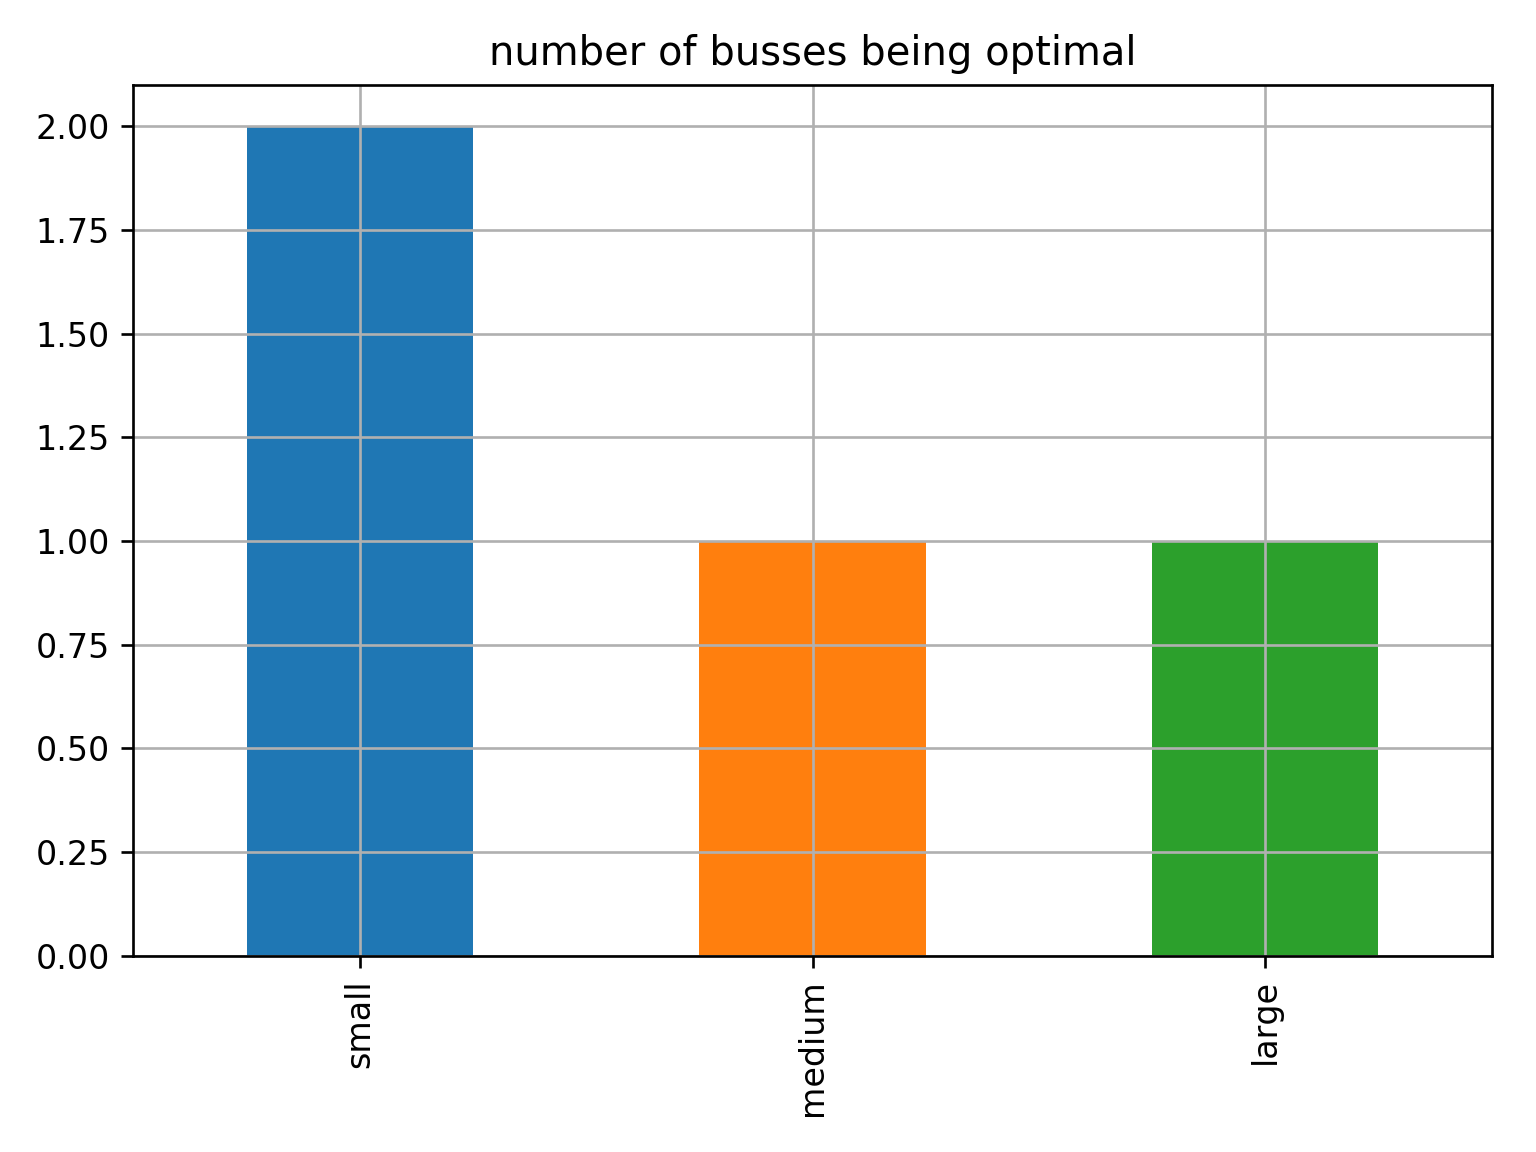

In [7]:
fig, ax = plt.subplots()
pd.Series(instance.busses.get_values())[['small', 'medium', 'large']].plot(kind='bar', ax=ax, grid=True)
ax.set_title('number of busses being optimal')
plt.tight_layout()

In [8]:
res = pd.Series(instance.busses_disp.get_values()).swaplevel().unstack()

<IPython.core.display.Javascript object>


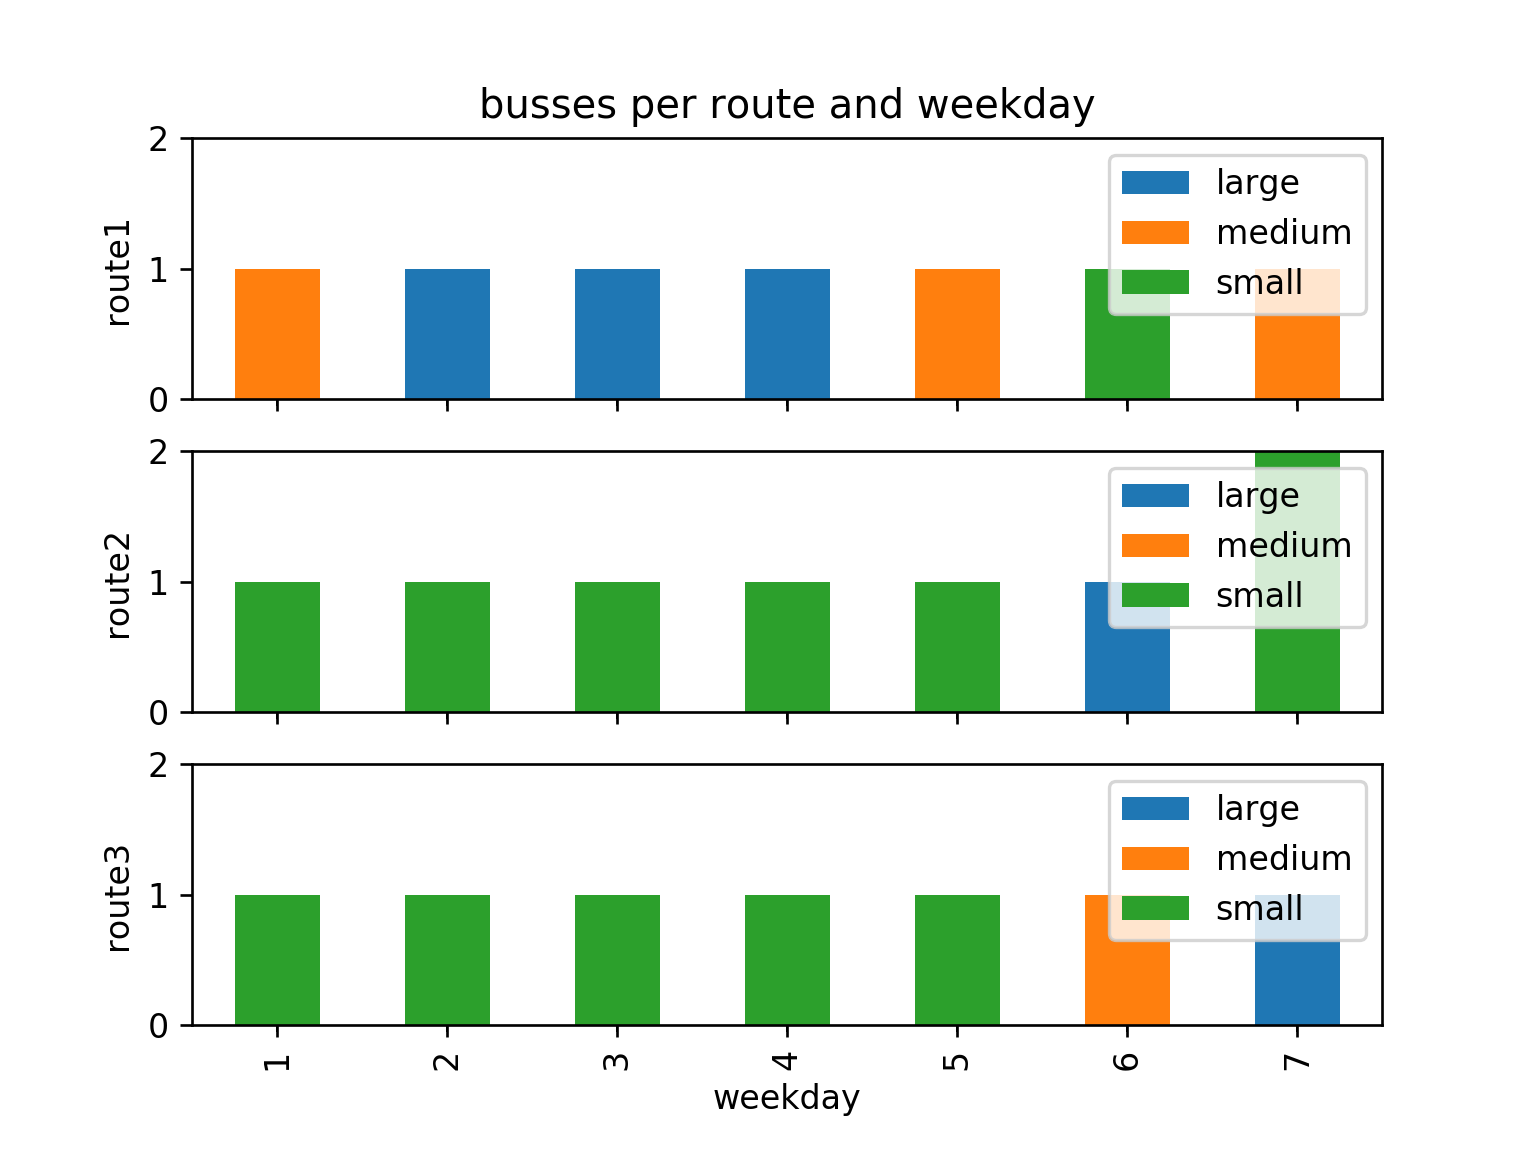

Text(0.5, 1.0, 'busses per route and weekday')

In [9]:
fig, ax = plt.subplots(nrows=3, sharex=True)
for i, route in enumerate(res.columns):
    res.loc[:, route].unstack().T.plot(kind='bar', stacked=True, ax=ax[i])
    ax[i].set_ylim(0, 2)
    ax[i].set_ylabel(route)
ax[i].legend()
ax[i].set_xlabel('weekday')
ax[0].set_title('busses per route and weekday')